In [1]:
# Import libraries needed for network analysis
import networkx as nx
import random
from infomap import Infomap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# Import directed graph from .txt edge list
G = nx.read_edgelist('AmazonGraph.txt', 
                     create_using=nx.DiGraph(), 
                     nodetype=int,
                     data=False)

print(f"Graph loaded successfully!")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Graph loaded successfully!
Number of nodes: 50000
Number of edges: 162551


### Centrality Analysis

In [3]:
# Calculate Degree Centrality
print("Computing Degree Centrality...")
degree_centrality = nx.degree_centrality(G)

# Show the top 10 nodes
print("\nTop 10 nodes by Degree Centrality:")
top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
for node, score in top_degree:
    print(f"  Node {node}: {score:.6f}")

Computing Degree Centrality...

Top 10 nodes by Degree Centrality:
  Node 548091: 0.010980
  Node 515301: 0.004660
  Node 502784: 0.004420
  Node 296016: 0.004340
  Node 239107: 0.004180
  Node 501444: 0.003340
  Node 317053: 0.003060
  Node 186356: 0.002940
  Node 502086: 0.002580
  Node 440342: 0.002560


In [4]:
# Calculate PageRank for each node
# alpha=0.85 is the standard damping parameter
print("\nComputing PageRank...")
pagerank = nx.pagerank(G, alpha=0.85, max_iter=100)

# Show the top 10 most important nodes
print("\nTop 10 nodes by PageRank:")
top_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:10]
for node, score in top_pagerank:
    print(f"  Node {node}: {score:.6f}")


Computing PageRank...

Top 10 nodes by PageRank:
  Node 548091: 0.002062
  Node 502784: 0.001446
  Node 296016: 0.001369
  Node 515301: 0.001338
  Node 265965: 0.001245
  Node 502086: 0.001245
  Node 425735: 0.001225
  Node 335281: 0.001218
  Node 180888: 0.001178
  Node 186356: 0.001136


In [5]:
# Calculate Eigenvector Centrality
print("Computing Eigenvector Centrality...")
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000, tol=1e-6)

# Show the top 10 nodes
print("\nTop 10 nodes by Eigenvector Centrality:")
top_eigenvector = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
for node, score in top_eigenvector:
    print(f"  Node {node}: {score:.6f}")

Computing Eigenvector Centrality...

Top 10 nodes by Eigenvector Centrality:
  Node 335281: 0.353086
  Node 75075: 0.288180
  Node 244004: 0.288180
  Node 220967: 0.274488
  Node 359489: 0.274488
  Node 427211: 0.167548
  Node 502086: 0.147663
  Node 148927: 0.128078
  Node 148932: 0.127968
  Node 32862: 0.127446


### Community Detection

Infomap is a strong community-detection algorithm for directed graphs. Therefore, we used it for this portion of the notebook, as well as in our Shiny app.

In [6]:
# Use Infomap to find communities in the network
print("Running Infomap community detection...")
im = Infomap(directed=True, silent=True)

# Add all the edges to Infomap
for u, v in G.edges():
    im.add_link(u, v)

# Run the algorithm
im.run()

# Get the communities from the results
communities = {}
node_to_community = {}

for node in im.nodes:
    node_id = node.node_id
    module_id = node.module_id
    # Add node to its community
    if module_id not in communities:
        communities[module_id] = []
    communities[module_id].append(node_id)
    node_to_community[node_id] = module_id

# Print some statistics
print(f"\nTotal communities found: {len(communities)}")
print(f"Codelength (compression): {im.codelength:.4f}")

# Look at community sizes
community_sizes = sorted([len(nodes) for nodes in communities.values()], reverse=True)
print(f"\nLargest communities (top 10):")
for i, size in enumerate(community_sizes[:10], 1):
    print(f"  Community {i}: {size} nodes")

print(f"\nSmallest community: {community_sizes[-1]} nodes")
print(f"Average community size: {sum(community_sizes)/len(community_sizes):.2f} nodes")

# Save community info to the graph
nx.set_node_attributes(G, node_to_community, 'community')

Running Infomap community detection...

Total communities found: 19
Codelength (compression): 3.8242

Largest communities (top 10):
  Community 1: 14396 nodes
  Community 2: 6715 nodes
  Community 3: 4330 nodes
  Community 4: 3983 nodes
  Community 5: 3795 nodes
  Community 6: 3679 nodes
  Community 7: 2754 nodes
  Community 8: 2495 nodes
  Community 9: 2318 nodes
  Community 10: 1788 nodes

Smallest community: 36 nodes
Average community size: 2631.58 nodes


Network Community Analysis:
Number of detected communities: 19
Modularity Q: 0.8467
(Q ranges from -0.5 to 1.0; higher is better)



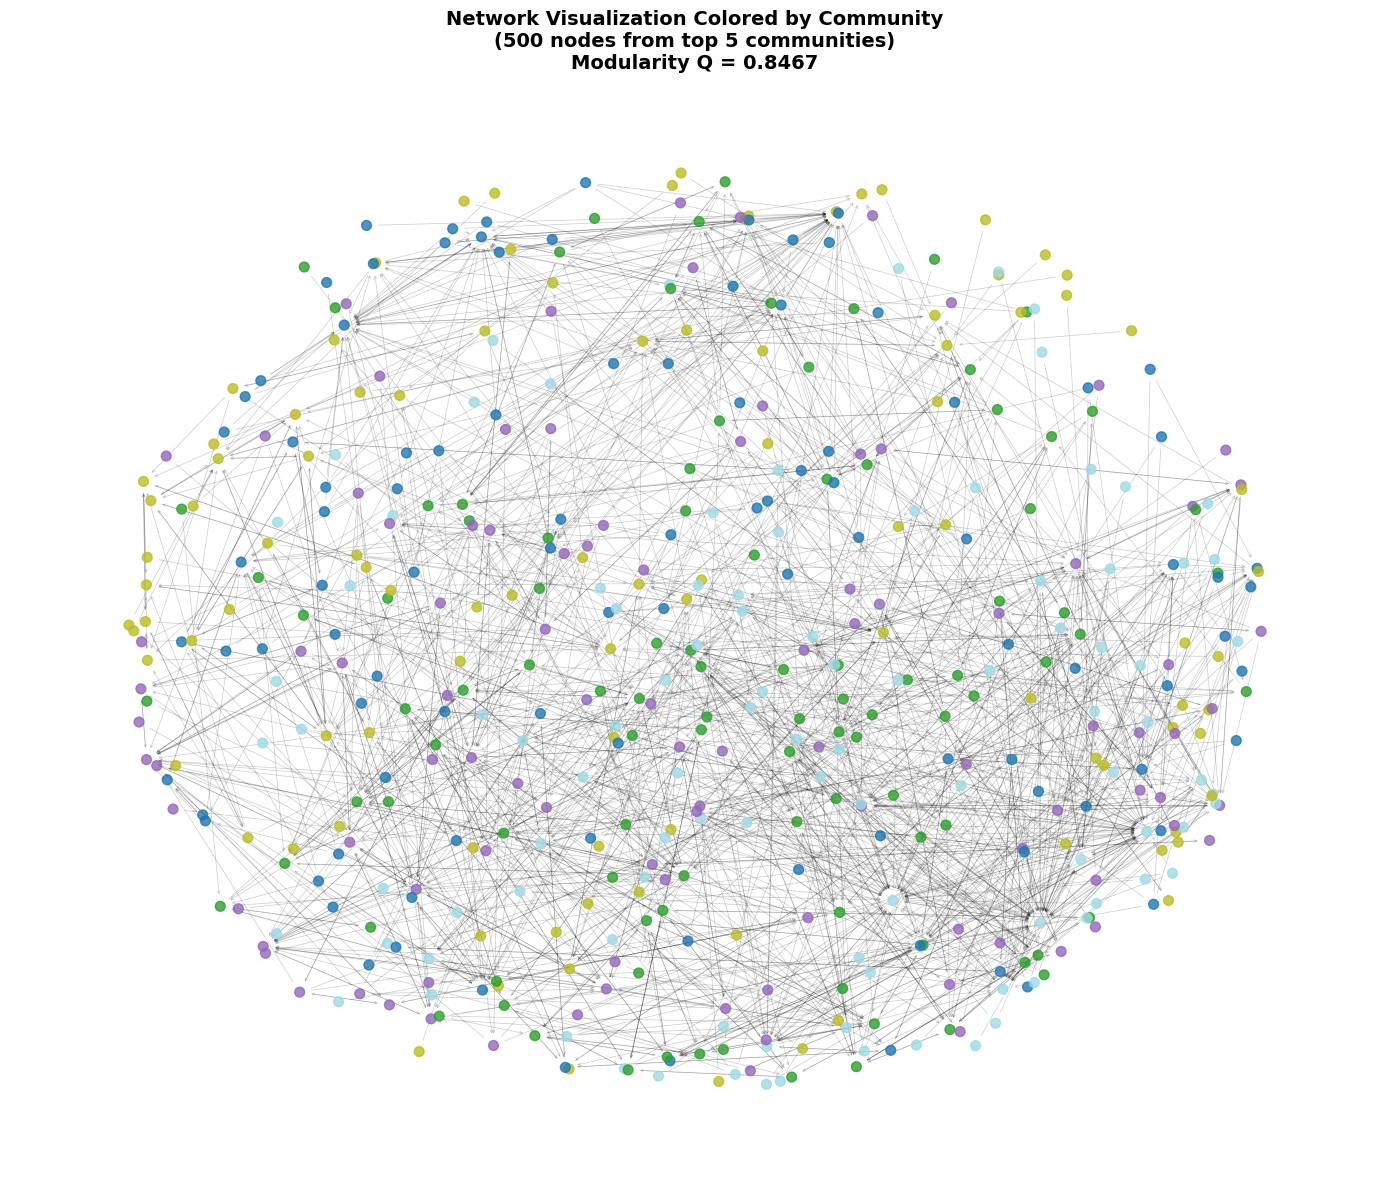

Visualized 500 nodes and 1599 edges from the largest communities.


In [7]:
# Visualize the communities and calculate modularity

# Calculate modularity Q value
community_sets = [set(nodes) for nodes in communities.values()]
modularity_q = nx.algorithms.community.modularity(G, community_sets)

print(f"Network Community Analysis:")
print(f"Number of detected communities: {len(communities)}")
print(f"Modularity Q: {modularity_q:.4f}")
print(f"(Q ranges from -0.5 to 1.0; higher is better)\n")

# Sample some nodes to visualize (can't plot all of them)
# Just take nodes from the biggest communities
n_nodes_to_sample = 500
largest_community_ids = sorted(communities.keys(), 
                               key=lambda x: len(communities[x]), 
                               reverse=True)[:5]
nodes_to_plot = []
for comm_id in largest_community_ids:
    nodes_to_plot.extend(communities[comm_id][:n_nodes_to_sample // 5])

# Create subgraph
G_sample = G.subgraph(nodes_to_plot).copy()

# Assign colors based on community
node_colors = [node_to_community[node] for node in G_sample.nodes()]

# Create visualization
plt.figure(figsize=(14, 12))

# Use spring layout for better visualization
pos = nx.spring_layout(G_sample, k=0.5, iterations=50, seed=42)

# Draw the network
nx.draw_networkx_nodes(G_sample, pos, 
                       node_color=node_colors,
                       node_size=50,
                       cmap='tab20',
                       alpha=0.8)

nx.draw_networkx_edges(G_sample, pos, 
                       alpha=0.2,
                       width=0.5,
                       arrows=True,
                       arrowsize=5,
                       arrowstyle='->')

plt.title(f'Network Visualization Colored by Community\n({len(G_sample.nodes())} nodes from top 5 communities)\nModularity Q = {modularity_q:.4f}', 
          fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"Visualized {len(G_sample.nodes())} nodes and {len(G_sample.edges())} edges from the largest communities.")

### Diffusion or Threshold Modeling

On average, each product has multiple products linked to it, and each product links to several other products. This faciliates diffusion or "infection", which represents purchasing trends among products.

In [8]:
# Pick seed nodes for the diffusion models
# Using out-degree first, then in-degree to break ties since many nodes have max out-degree of 5
node_scores = []
for node in G.nodes():
    out_deg = G.out_degree(node)
    in_deg = G.in_degree(node)
    combined_score = (out_deg, in_deg)
    node_scores.append((node, out_deg, in_deg, combined_score))

# Sort and get top 10
top_seeds = sorted(node_scores, key=lambda x: x[3], reverse=True)[:10]
seed_nodes = [node for node, out_deg, in_deg, score in top_seeds]

print("Selected top 10 seed nodes:")
print("\n  Node | Out-Degree | In-Degree | Total")
print("-" * 40)
for node, out_deg, in_deg, score in top_seeds:
    print(f"{node:6d} | {out_deg:10d} | {in_deg:9d} | {out_deg + in_deg:5d}")
    
print(f"\nSeed nodes: {seed_nodes}")

Selected top 10 seed nodes:

  Node | Out-Degree | In-Degree | Total
----------------------------------------
515301 |          5 |       228 |   233
502784 |          5 |       216 |   221
296016 |          5 |       212 |   217
501444 |          5 |       162 |   167
317053 |          5 |       148 |   153
186356 |          5 |       142 |   147
502086 |          5 |       124 |   129
440342 |          5 |       123 |   128
180888 |          5 |       116 |   121
547040 |          5 |       107 |   112

Seed nodes: [515301, 502784, 296016, 501444, 317053, 186356, 502086, 440342, 180888, 547040]


#### SI Model

"Infection" represents a product being purchased. Tracking "infected" products = tracking customer interest. Each infected product can "infect" other products (customers buy linked products).

In [10]:
def si_model(G, seed_nodes, beta=0.3, max_steps=20):
    infected = set(seed_nodes)
    infected_over_time = [len(infected)]
    
    for step in range(max_steps):
        newly_infected = set()
        
        for node in infected:
            neighbors = list(G.successors(node))
            
            for neighbor in neighbors:
                if neighbor not in infected:
                    if random.random() < beta:
                        newly_infected.add(neighbor)

        # Updated infected count after each timestep
        infected.update(newly_infected)
        infected_over_time.append(len(infected))
        
        # Stop if nothing new got infected
        if len(newly_infected) == 0:
            print(f"SI model converged at step {step + 1}")
            break
    
    return infected_over_time, infected

beta = 0.3

# Run SI model
print("Running SI Model...")
print(f"Initial seed nodes: {seed_nodes}")
print(f"Infection probability (beta): {beta}\n")

cumulative_infected, final_infected = si_model(G, seed_nodes, beta=beta, max_steps=20)

print(f"\nFinal Results:")
print(f"Total infected nodes: {len(final_infected)}")
print(f"Percentage of network infected: {100 * len(final_infected) / G.number_of_nodes():.2f}%")
print(f"Total timesteps: {len(cumulative_infected) - 1}")

Running SI Model...
Initial seed nodes: [515301, 502784, 296016, 501444, 317053, 186356, 502086, 440342, 180888, 547040]
Infection probability (beta): 0.3


Final Results:
Total infected nodes: 710
Percentage of network infected: 1.42%
Total timesteps: 20


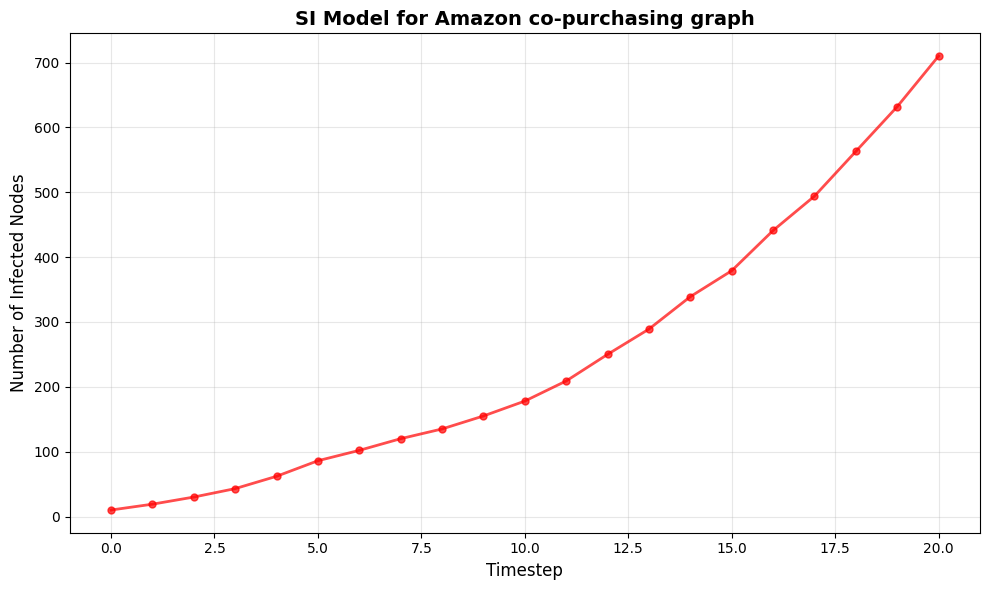

In [11]:
# Plot infected nodes over time
plt.figure(figsize=(10, 6))

plt.plot(range(len(cumulative_infected)), cumulative_infected, 
         'r-', linewidth=2, marker='o', markersize=5, alpha=0.7)

plt.xlabel('Timestep', fontsize=12)
plt.ylabel('Number of Infected Nodes', fontsize=12)
plt.title('SI Model for Amazon co-purchasing graph', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### SIR Model

Adds "recovery", so products "recover" after some time. This represents declining customer interest or seasonal products losing popularity.

In [12]:
def sir_model(G, seed_nodes, beta=0.3, gamma=0.15, max_steps=20):
    susceptible = set(G.nodes()) - set(seed_nodes)
    infected = set(seed_nodes)
    recovered = set()
    
    s_over_time = [len(susceptible)]
    i_over_time = [len(infected)]
    r_over_time = [len(recovered)]
    
    for step in range(max_steps):
        newly_infected = set()
        newly_recovered = set()
        
        # Each node may infect its neighbors
        for node in infected:
            neighbors = list(G.successors(node))
            
            for neighbor in neighbors:
                if neighbor in susceptible:
                    if random.random() < beta:
                        newly_infected.add(neighbor)
        
        # Recovery probability
        for node in infected:
            if random.random() < gamma:
                newly_recovered.add(node)
        
        # Update all states
        susceptible -= newly_infected
        infected -= newly_recovered
        infected |= newly_infected
        recovered |= newly_recovered
        
        s_over_time.append(len(susceptible))
        i_over_time.append(len(infected))
        r_over_time.append(len(recovered))
        
        # Stop if no one is infected anymore
        if len(infected) == 0:
            print(f"SIR model converged at step {step + 1} (no infected nodes remain)")
            break
    
    return s_over_time, i_over_time, r_over_time

beta = 0.3
gamma = 0.15

# Run SIR model
print("Running SIR Model...")
print(f"Initial seed nodes: {seed_nodes}")
print(f"Infection probability (beta): {beta}")
print(f"Recovery probability (gamma): {gamma}\n")

s_counts, i_counts, r_counts = sir_model(G, seed_nodes, beta=beta, gamma=gamma, max_steps=20)

print(f"\nFinal Results:")
print(f"Susceptible nodes: {s_counts[-1]}")
print(f"Infected nodes: {i_counts[-1]}")
print(f"Recovered nodes: {r_counts[-1]}")
print(f"Total timesteps: {len(i_counts) - 1}")
print(f"Percentage recovered: {100 * r_counts[-1] / G.number_of_nodes():.2f}%")

Running SIR Model...
Initial seed nodes: [515301, 502784, 296016, 501444, 317053, 186356, 502086, 440342, 180888, 547040]
Infection probability (beta): 0.3
Recovery probability (gamma): 0.15


Final Results:
Susceptible nodes: 49821
Infected nodes: 70
Recovered nodes: 109
Total timesteps: 20
Percentage recovered: 0.22%


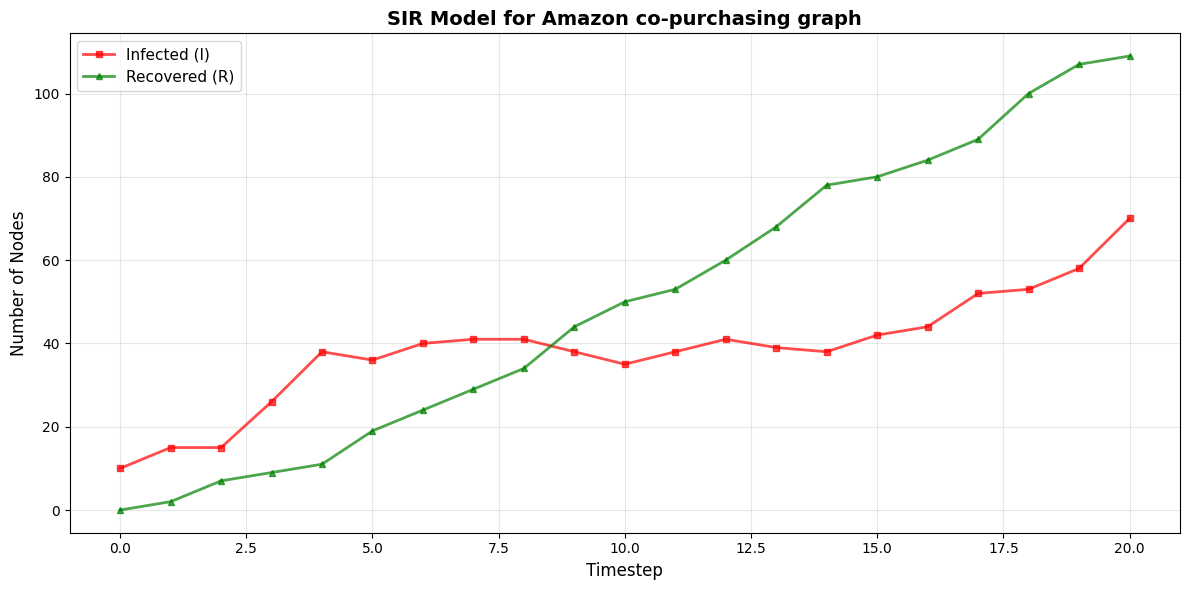


Peak infection: 70 nodes at timestep 20


In [13]:
# Plot I and R over time
plt.figure(figsize=(12, 6))

timesteps = range(len(i_counts))

plt.plot(timesteps, i_counts, 'r-', linewidth=2, marker='s', 
         markersize=4, label='Infected (I)', alpha=0.7)
plt.plot(timesteps, r_counts, 'g-', linewidth=2, marker='^', 
         markersize=4, label='Recovered (R)', alpha=0.7)

plt.xlabel('Timestep', fontsize=12)
plt.ylabel('Number of Nodes', fontsize=12)
plt.title('SIR Model for Amazon co-purchasing graph', fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate peak infection
peak_infected = max(i_counts)
peak_time = i_counts.index(peak_infected)
print(f"\nPeak infection: {peak_infected} nodes at timestep {peak_time}")

### Model Comparison

Comparing the real Amazon network with Erdos-Renyi, Watts-Strogatz, and Barabasi-Albert simulated graphs. (These graphs are then converted to directed graphs, since the Amazon graph is directed.)

In [15]:
# Use a smaller sample for comparison
n_sample = 5000  # Sample size for comparison
n = G.number_of_nodes()
m = G.number_of_edges()
avg_degree = 2 * m / n

print(f"Amazon Network Parameters:")
print(f"Nodes (n): {n}")
print(f"Edges (m): {m}")
print(f"Average degree: {avg_degree:.2f}")
print()

# Sample the real network using BFS to preserve connectivity
random.seed(42)

# Start from a random seed node and do BFS
start_node = random.choice(list(G.nodes()))
sampled_nodes = set()
queue = [start_node]
visited = {start_node}

while len(sampled_nodes) < n_sample and queue:
    node = queue.pop(0)
    sampled_nodes.add(node)
    
    # Get neighbors (both successors and predecessors for better connectivity)
    neighbors = list(set(G.successors(node)) | set(G.predecessors(node)))
    random.shuffle(neighbors)  # Randomize order to avoid bias
    
    for neighbor in neighbors:
        if neighbor not in visited and len(sampled_nodes) + len(queue) < n_sample:
            visited.add(neighbor)
            queue.append(neighbor)

# Create subgraph from BFS sample
G_sample = G.subgraph(list(sampled_nodes)).copy()
print(f"Amazon (5000-node BFS sample): {G_sample.number_of_nodes()} nodes, {G_sample.number_of_edges()} edges")

# 1. Erdos-Renyi
p_er = avg_degree / (n_sample - 1)
G_er = nx.erdos_renyi_graph(n_sample, p_er, directed=True)
print(f"Erdos-Renyi: {G_er.number_of_nodes()} nodes, {G_er.number_of_edges()} edges")

# 2. Watts-Strogatz
k_ws = max(4, int(avg_degree))
if k_ws % 2 == 1:  # k needs to be even
    k_ws += 1
p_ws = 0.1
G_ws = nx.watts_strogatz_graph(n_sample, k_ws, p_ws)
G_ws = G_ws.to_directed()
print(f"Watts-Strogatz: {G_ws.number_of_nodes()} nodes, {G_ws.number_of_edges()} edges")

# 3. Barabasi-Albert
m_ba = max(1, int(avg_degree / 2))
G_ba = nx.barabasi_albert_graph(n_sample, m_ba)
G_ba = G_ba.to_directed()
print(f"Barabasi-Albert: {G_ba.number_of_nodes()} nodes, {G_ba.number_of_edges()} edges")

Amazon Network Parameters:
Nodes (n): 50000
Edges (m): 162551
Average degree: 6.50

Amazon (5000-node BFS sample): 5000 nodes, 15510 edges
Erdos-Renyi: 5000 nodes, 32537 edges
Watts-Strogatz: 5000 nodes, 30000 edges
Barabasi-Albert: 5000 nodes, 29982 edges


In [16]:
# Compare network properties

def analyze_network(G, name):
    # Convert to undirected for certain calculations
    G_undirected = G.to_undirected()
    
    # Degree statistics
    degrees = dict(G.degree())
    degree_vals = list(degrees.values())
    avg_degree = np.mean(degree_vals)
    max_degree = max(degree_vals)
    
    # Average clustering coefficient
    avg_clustering = nx.average_clustering(G_undirected)
    
    # Largest connected component
    components = list(nx.connected_components(G_undirected))
    gcc = G_undirected.subgraph(max(components, key=len))
    
    # Average path length
    avg_path_length = nx.average_shortest_path_length(gcc)
    
    # Print results
    print(f"\n{name}:")
    print(f"  Average Clustering Coefficient: {avg_clustering:.4f}")
    print(f"  Average Path Length (LCC): {avg_path_length:.4f}")
    print(f"  Average Degree: {avg_degree:.2f}")
    print(f"  Max Degree: {max_degree}")
    print(f"  Nodes in largest component: {gcc.number_of_nodes()} ({100*gcc.number_of_nodes()/G.number_of_nodes():.1f}%)")
    
    return {
        'name': name,
        'clustering': avg_clustering,
        'path_length': avg_path_length,
        'avg_degree': avg_degree,
        'max_degree': max_degree,
        'degrees': degree_vals
    }

# Analyze all four networks (using sampled Amazon graph)
print("\nAnalyzing network properties...")
results = []
results.append(analyze_network(G_sample, "Amazon (BFS sampled)"))
results.append(analyze_network(G_er, "Erdos-Renyi (Random)"))
results.append(analyze_network(G_ws, "Watts-Strogatz (Small-World)"))
results.append(analyze_network(G_ba, "Barabasi-Albert (Scale-Free)"))


Analyzing network properties...

Amazon (BFS sampled):
  Average Clustering Coefficient: 0.4141
  Average Path Length (LCC): 7.3334
  Average Degree: 6.20
  Max Degree: 87
  Nodes in largest component: 5000 (100.0%)

Erdos-Renyi (Random):
  Average Clustering Coefficient: 0.0027
  Average Path Length (LCC): 3.6072
  Average Degree: 13.01
  Max Degree: 29
  Nodes in largest component: 5000 (100.0%)

Watts-Strogatz (Small-World):
  Average Clustering Coefficient: 0.4429
  Average Path Length (LCC): 7.8836
  Average Degree: 12.00
  Max Degree: 20
  Nodes in largest component: 5000 (100.0%)

Barabasi-Albert (Scale-Free):
  Average Clustering Coefficient: 0.0091
  Average Path Length (LCC): 4.0382
  Average Degree: 11.99
  Max Degree: 412
  Nodes in largest component: 5000 (100.0%)


### Creative or Extended Analysis

As an extension of our current analysis, we are interested in the metadata of each product node. This will allow us to find trends between products that form communities, and this will be a key part of our Shiny app.

In [17]:
# Load product information and look at the most popular products

# Read the product metadata CSV
products_df = pd.read_csv('metadata.csv')
print(f"Loaded {len(products_df)} products from metadata\n")

# Set ProductId as the index so we can look up products by node ID
products_df = products_df.set_index('ProductId')

# Get the top 20 most popular products based on PageRank
top_nodes = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:20]

print("Top 20 Products by PageRank)")

# Print info for each top product
for rank, (node, pr_score) in enumerate(top_nodes, 1):
    if node in products_df.index:
        product = products_df.loc[node]
        print(f"\n{rank}. Node {node} (PageRank: {pr_score:.6f})")
        print(f"   Title: {product['title']}")
        print(f"   Group: {product['group']}")
        print(f"   Sales Rank: {int(product['salesrank']) if pd.notna(product['salesrank']) else 'N/A'}")
        print(f"   Reviews: {int(product['total_review_count'])} | Avg Rating: {product['average_rating']:.1f}/5.0")
        print(f"   In-Degree: {G.in_degree(node)} | Out-Degree: {G.out_degree(node)}")
    else:
        print(f"\n{rank}. Node {node} (PageRank: {pr_score:.6f})")
        print(f"   [Product metadata not available]")
        print(f"   In-Degree: {G.in_degree(node)} | Out-Degree: {G.out_degree(node)}")

# Look at some summary stats for these top products

print("\nSummary Statistics")

top_node_ids = [node for node, _ in top_nodes if node in products_df.index]
if top_node_ids:
    top_products = products_df.loc[top_node_ids]
    
    print("\nProduct Categories in Top 20:")
    group_counts = top_products['group'].value_counts()
    for group, count in group_counts.items():
        print(f"  {group}: {count}")
    
    print(f"\nAverage Rating: {top_products['average_rating'].mean():.2f}/5.0")
    print(f"Average Reviews: {top_products['total_review_count'].mean():.1f}")
    print(f"Median Sales Rank: {top_products['salesrank'].median():.0f}")


Loaded 50000 products from metadata

Top 20 Products by PageRank)

1. Node 548091 (PageRank: 0.002062)
   Title: Laura
   Group: DVD
   Sales Rank: 110
   Reviews: 83 | Avg Rating: 5.0/5.0
   In-Degree: 549 | Out-Degree: 0

2. Node 502784 (PageRank: 0.001446)
   Title: Brown Bear, Brown Bear, What Do You See?
   Group: Book
   Sales Rank: 171
   Reviews: 172 | Avg Rating: 5.0/5.0
   In-Degree: 216 | Out-Degree: 5

3. Node 296016 (PageRank: 0.001369)
   Title: Easy Spanish Phrase Book: Over 770 Basic Phrases for Everyday Use
   Group: Book
   Sales Rank: 122
   Reviews: 13 | Avg Rating: 5.0/5.0
   In-Degree: 212 | Out-Degree: 5

4. Node 515301 (PageRank: 0.001338)
   Title: 1001 Most Useful Spanish Words (Beginners' Guides)
   Group: Book
   Sales Rank: 290
   Reviews: 35 | Avg Rating: 4.5/5.0
   In-Degree: 228 | Out-Degree: 5

5. Node 265965 (PageRank: 0.001245)
   Title: Chronicles, Vol. 1
   Group: Book
   Sales Rank: 651
   Reviews: 176 | Avg Rating: 4.0/5.0
   In-Degree: 118 | Out-